In [2]:
import os
os.chdir("/home/haok/MoE-Research")

from pathlib import Path
from typing import Tuple, List, Optional

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch import Tensor
from matplotlib.ticker import FuncFormatter

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-12b")


In [3]:
def load(
    checkpoint_step: int,
    layer_number: int = 18,
    expert_index: int = 24,
    min_samples: int = 100,
    top_k: int = 5,
    indices: Optional[List[int]] = None,
) -> Tuple[Tensor, Tensor]:

    # Load the data in a safe fashion
    data = torch.load(
        f"/project/flame/haok/results/expert-specialization/flame-moe-1.7b/"
        f"{checkpoint_step}/{layer_number}-{expert_index}.pt"
    )
    assert isinstance(data, tuple) and len(data) == 2
    assert isinstance(data[0], Tensor) and isinstance(data[1], Tensor)

    # Fraction of times this expert activates a given token
    sample_count, active_count = data
    specialization = torch.where(
        sample_count > 0,
        active_count.float() / sample_count.float(),
        torch.zeros_like(sample_count, dtype=torch.float)
    )

    # If desired, load those particular tokens
    if indices is not None:
        return specialization[[indices]], torch.Tensor(indices)

    # Mask out low-sample entries
    specialization = torch.where(
        sample_count >= min_samples,
        specialization,
        torch.tensor(float('-inf'))
    )

    # Select the top-k most specialized tokens
    pack = specialization.topk(k=top_k)
    return pack.values, pack.indices


In [20]:
expert_indices = torch.arange(0, 64)

layer_number, min_samples, top_k = 18, 5, 2
last_indices = torch.zeros(expert_indices.max() + 1, top_k, dtype=torch.int64)

for expert_index in expert_indices:
    values, indices = load(
        checkpoint_step=11029,
        layer_number=layer_number, expert_index=expert_index,
        min_samples=min_samples, top_k=top_k
    )
    last_indices[expert_index] = indices

lines: List[Tuple[int, List[Tuple[int, List[float]]]]] = []
for expert_index in expert_indices:
    line = []
    for checkpoint_step in [1100, 2200, 4400, 5500, 6600, 7700, 8800, 9900, 11029]:
        values, indices = load(
            checkpoint_step=checkpoint_step,
            layer_number=layer_number, expert_index=expert_index,
            indices=last_indices[expert_index],
        )
        line.append((checkpoint_step, values.tolist()))
        print(
            f"checkpoint={checkpoint_step} layer={layer_number} expert={expert_index} |".rjust(36), 
            values, indices, [tokenizer.decode(tid) for tid in indices],
        )
    lines.append((expert_index.item(), line))
    print("=" * 36)


 checkpoint=1100 layer=18 expert=0 | tensor([0.2000, 0.2500]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=2200 layer=18 expert=0 | tensor([0.2000, 0.2500]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=4400 layer=18 expert=0 | tensor([0.2000, 0.3750]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=5500 layer=18 expert=0 | tensor([0.8000, 0.5000]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=6600 layer=18 expert=0 | tensor([0.4000, 0.5000]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=7700 layer=18 expert=0 | tensor([0.6000, 0.3750]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=8800 layer=18 expert=0 | tensor([0.8000, 0.6250]) tensor([44394, 36474]) ['TextBox', ' univariate']
 checkpoint=9900 layer=18 expert=0 | tensor([0.6000, 0.6250]) tensor([44394, 36474]) ['TextBox', ' univariate']
checkpoint=11029 layer=18 expert=0 | tensor([0.8000, 0.6250]) tensor([44394, 36474]) ['TextBox', ' univa

In [ ]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

mpl.rcParams['font.family'] = 'Times New Roman'

def human_format(x, pos):
    if x >= 1e9:
        return f'{x/1e9:.0f}B'
    elif x >= 1e6:
        return f'{x/1e6:.0f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x}'

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, len(lines), figsize=(6 * len(lines) + 2, 4), sharey=True)

for i, (ax, (expert_id, series)) in enumerate(zip(axes, lines)):
    steps = [step for step, _ in series]
    value_lists = list(zip(*[vals for _, vals in series]))

    for j, scores in enumerate(value_lists):
        sns.lineplot(
            x=steps, y=scores, marker='o',
            ax=ax, label=f"Top-{j+1}",
            linewidth=4, markersize=16
        )

    ax.grid(False)
    ax.set_title(f"Expert-{expert_id}", fontsize=24)
    ax.set_ylabel("Score" if ax is axes[0] else "", fontsize=24)
    ax.set_xlabel("Training Steps", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.xaxis.set_major_formatter(FuncFormatter(human_format))

    # Remove legend for all but the last subplot
    if i != len(axes) - 1:
        ax.legend_.remove()

# Move legend to only the last subplot
handles, labels = axes[-1].get_legend_handles_labels()
axes[-1].legend(handles, labels, loc="upper left", frameon=False, fontsize=20, bbox_to_anchor=(-0.02, 1.04))

joined_ids = "-".join(str(expert_id) for expert_id, _ in lines)
file = Path(f"figures/expert-specialization/flame-moe-1.7b/{layer_number}/{joined_ids}.pdf")
file.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(file, bbox_inches='tight', pad_inches=0)
plt.show()


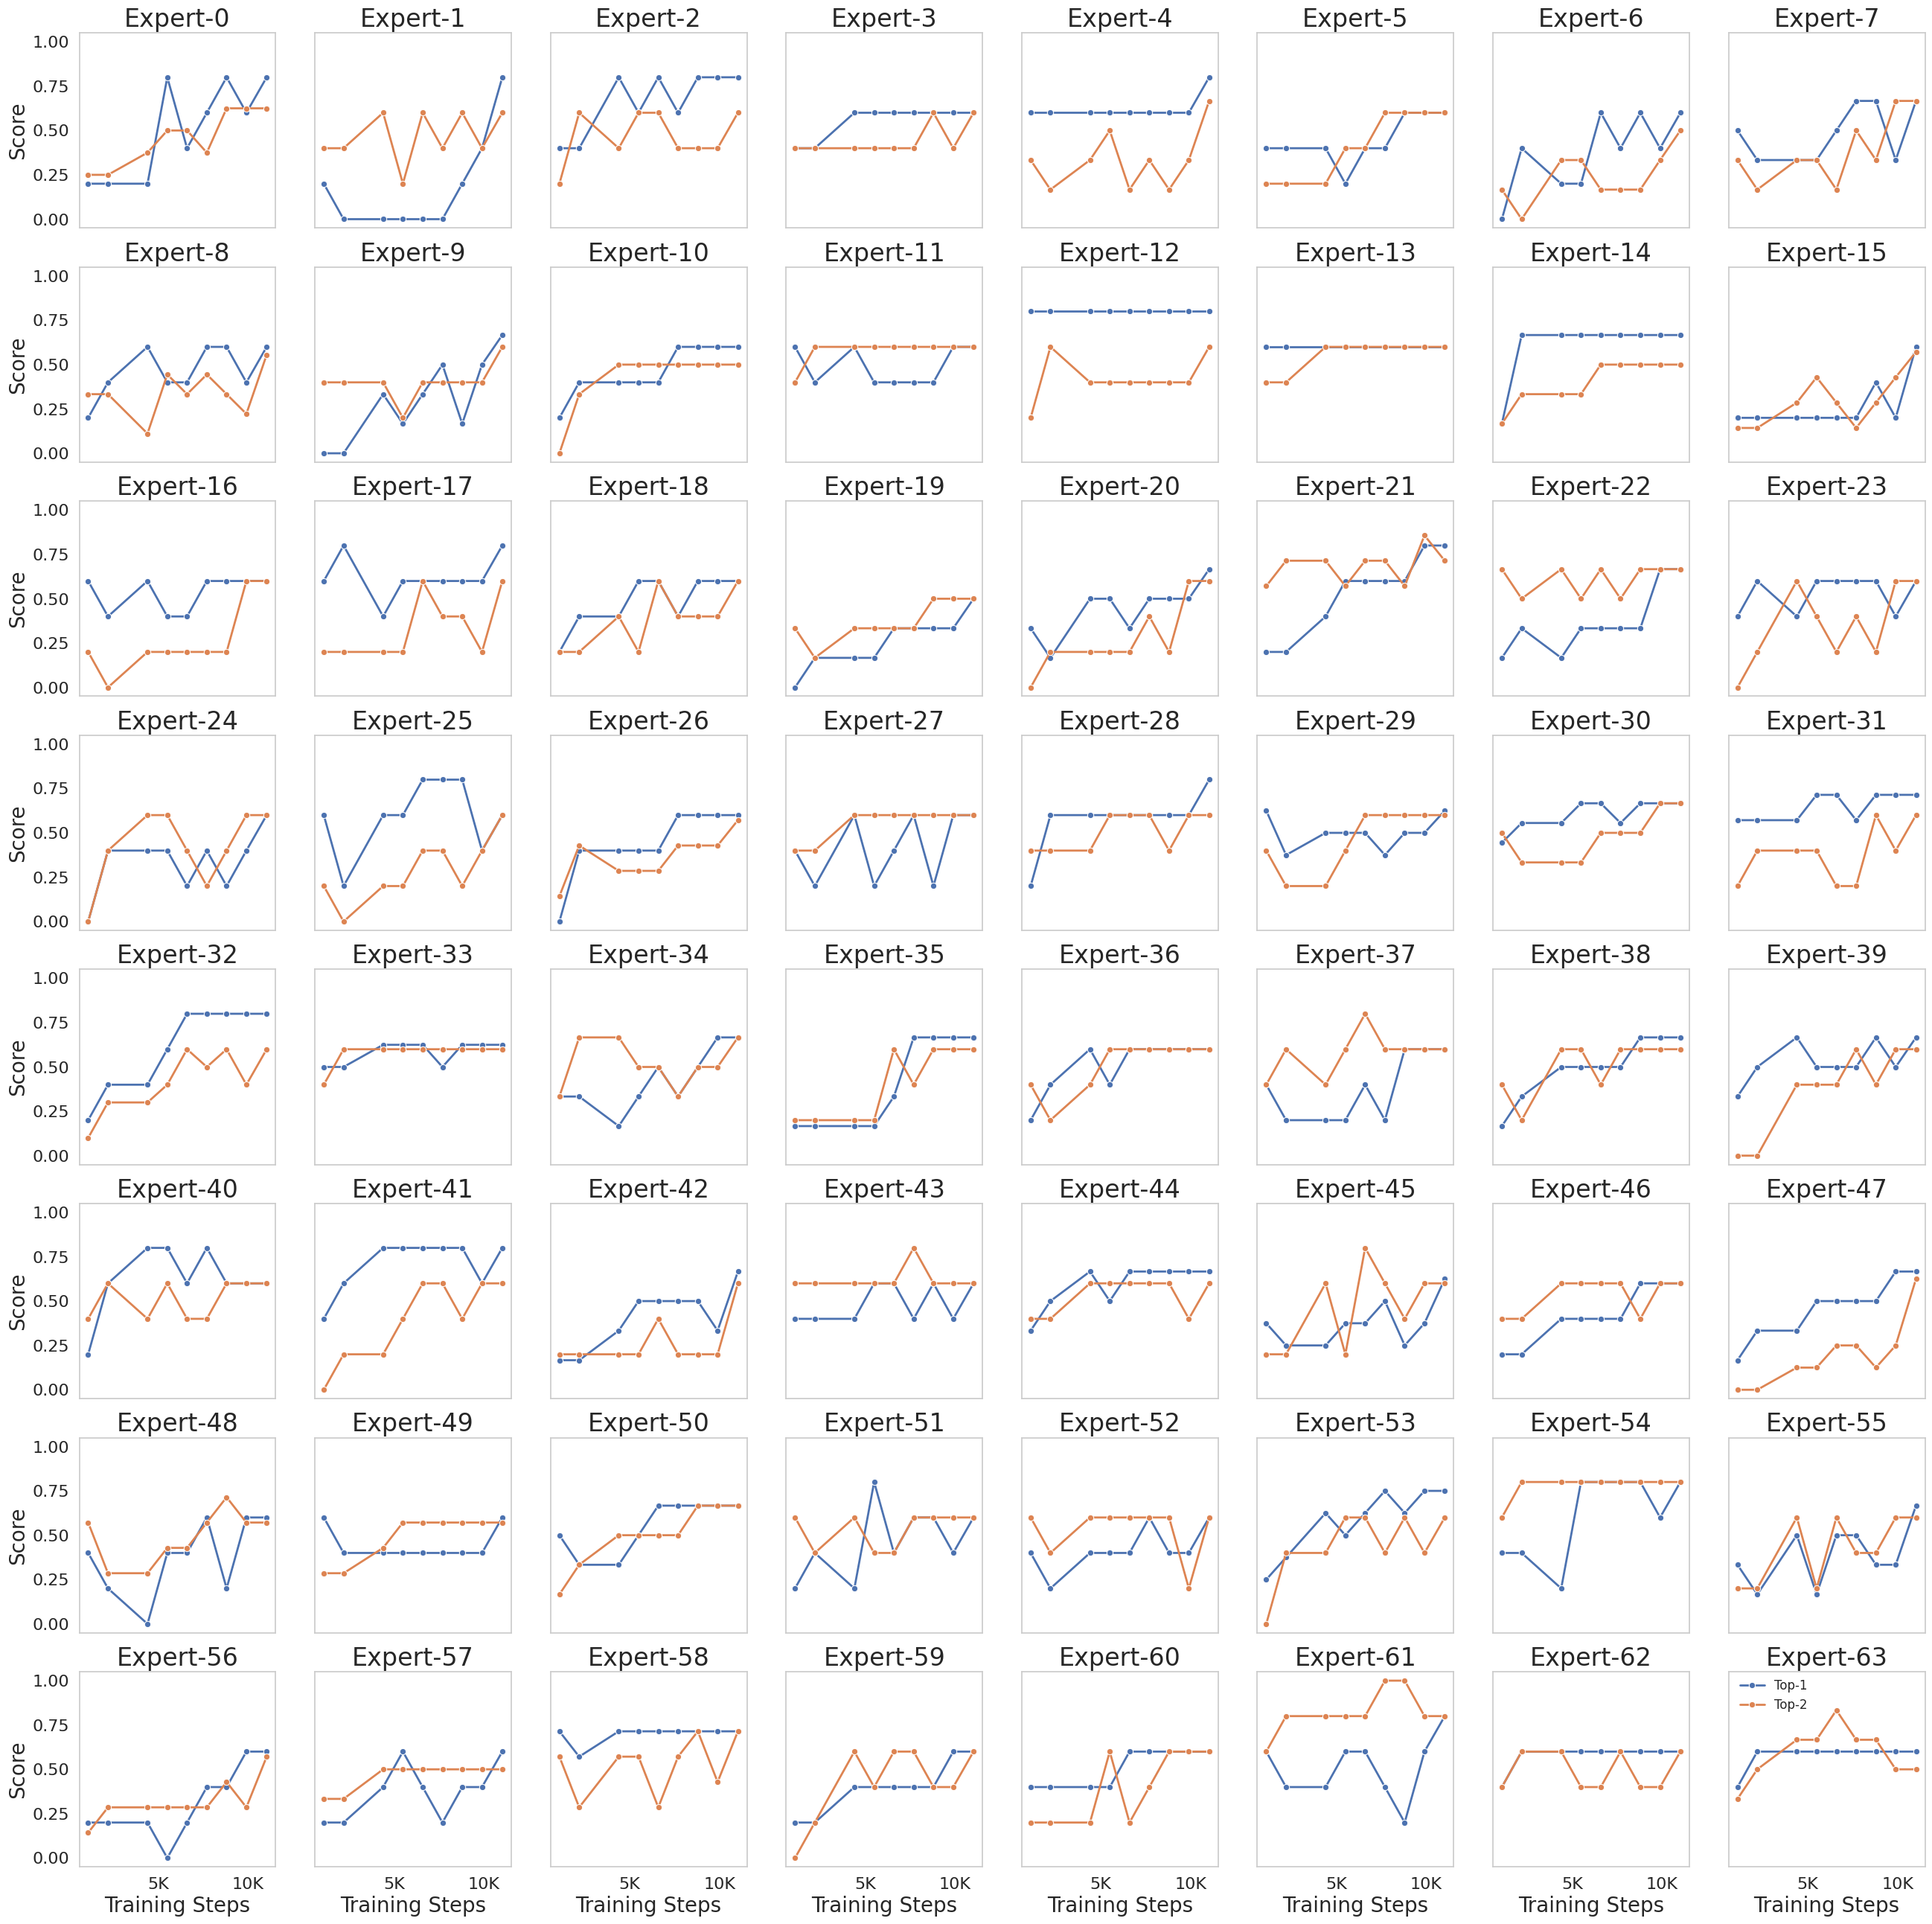

In [18]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

mpl.rcParams['font.family'] = 'Times New Roman'

def human_format(x, pos):
    if x >= 1e9:
        return f'{x/1e9:.0f}B'
    elif x >= 1e6:
        return f'{x/1e6:.0f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x}'

sns.set_theme(style="whitegrid")

# Create 8x8 subplots with shared axes
fig, axes = plt.subplots(8, 8, figsize=(32, 32), sharex=True, sharey=True)
axes = axes.flatten()

for i, ((expert_id, series), ax) in enumerate(zip(lines, axes)):
    steps = [step for step, _ in series]
    value_lists = list(zip(*[vals for _, vals in series]))

    for j, scores in enumerate(value_lists):
        sns.lineplot(
            x=steps, y=scores, marker='o',
            ax=ax, label=f"Top-{j+1}",
            linewidth=2, markersize=6
        )

    ax.grid(False)
    ax.set_title(f"Expert-{expert_id}", fontsize=24)

    # Only leftmost column gets y-axis label
    if i % 8 == 0:
        ax.set_ylabel("Score", fontsize=20)
    else:
        ax.set_ylabel("")

    # Only bottom row gets x-axis label
    if i // 8 == 7:
        ax.set_xlabel("Training Steps", fontsize=20)
    else:
        ax.set_xlabel("")
        ax.tick_params(labelbottom=False)

    ax.tick_params(axis='both', labelsize=16)
    ax.xaxis.set_major_formatter(FuncFormatter(human_format))

    # Remove legend for all but last used subplot
    if i != len(lines) - 1:
        ax.legend_.remove()

# Remove any unused subplots
for j in range(len(lines), 64):
    fig.delaxes(axes[j])

# Add legend to last used subplot
handles, labels = axes[len(lines)-1].get_legend_handles_labels()
axes[len(lines)-1].legend(handles, labels, loc="upper left", frameon=False, fontsize=12, bbox_to_anchor=(0, 1.02))

# Save figure
joined_ids = "-".join(str(expert_id) for expert_id, _ in lines)
file = Path(f"figures/expert-specialization/flame-moe-1.7b/{layer_number}/combined.pdf")
file.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(file, bbox_inches='tight', pad_inches=0)
plt.show()
